In [39]:
import torch
import torch.fft
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

# ================= 1. 参数设置 =================
IMAGE_PATH = "./1_1_0.90179.png"  # 你的图片路径
DISTANCE_MM = 0.01 
PIXEL_SIZE = 3.45e-6 
WAVELENGTHS = {'R': 660e-9, 'G': 532e-9, 'B': 450e-9}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 运行设备: {device}")

# ================= 2. 读取图片 =================
img_bgr = cv2.imread(IMAGE_PATH)

if img_bgr is None:
    print(f"⚠️ 无法读取图片: {IMAGE_PATH}")
    # 生成测试图防止代码中断
    H, W = 1024, 1024
    img_bgr = np.zeros((H, W, 3), dtype=np.uint8)
    cv2.circle(img_bgr, (512, 512), 100, (255, 255, 255), -1)
else:
    print(f"✅ 成功读取图片: {img_bgr.shape}")
    # 如果图片太大，建议缩小一点，否则 FFT 会很慢
    # img_bgr = cv2.resize(img_bgr, (1024, 1024)) 
    H, W = img_bgr.shape[:2]

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

🚀 运行设备: cuda
✅ 成功读取图片: (460, 620, 3)


In [40]:
# ================= 3. 逐通道物理传播 =================
propagated_channels = []
channel_names = ['R', 'G', 'B']

for i, color_name in enumerate(channel_names):
    channel_data = img_rgb[:, :, i]
    U0 = torch.from_numpy(channel_data).float().to(device) / 255.0
    U0_complex = U0.to(torch.complex64)
    
    lam = WAVELENGTHS[color_name]
    k = 2 * math.pi / lam
    z = DISTANCE_MM * 1e-3
    
    # ===【关键修改点】在这里加上 int() ===
    fx = torch.fft.fftfreq(int(W), d=PIXEL_SIZE, device=device)
    fy = torch.fft.fftfreq(int(H), d=PIXEL_SIZE, device=device)
    # ==================================
    
    FY, FX = torch.meshgrid(fy, fx, indexing='ij')
    
    squared_term = 1 - (lam * FX)**2 - (lam * FY)**2
    mask = squared_term >= 0
    phase_shift = k * z * torch.sqrt(torch.abs(squared_term)) * 2000
    H_transfer = torch.exp(1j * phase_shift) * mask
    
    U_freq = torch.fft.fft2(U0_complex)
    U_z_freq = U_freq * H_transfer
    U_z = torch.fft.ifft2(U_z_freq)
    
    I_z = torch.abs(U_z)
    I_z = torch.clamp(I_z, 0.0, 1.0)
    propagated_channels.append(I_z.cpu().numpy())

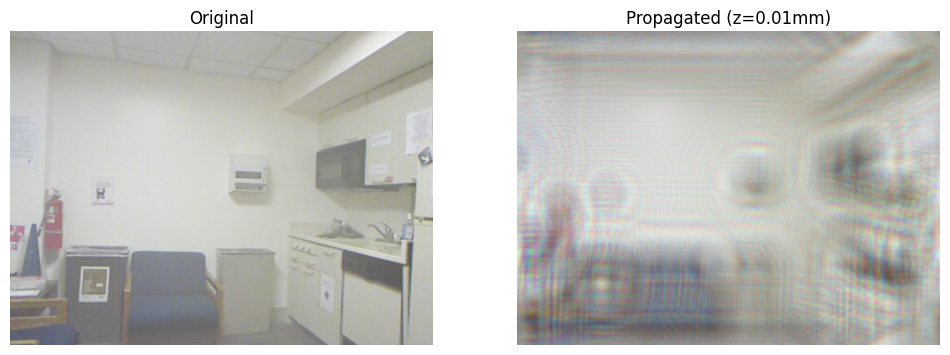

In [41]:
img_propagated = np.stack(propagated_channels, axis=2)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(img_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f"Propagated (z={DISTANCE_MM}mm)")
plt.imshow(img_propagated)
plt.axis('off')

plt.show()

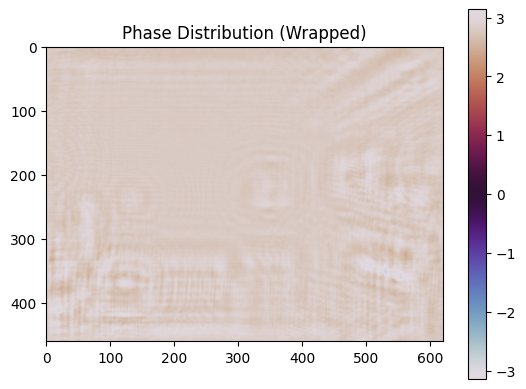

In [42]:
# 获取传播后的相位 (-pi 到 pi)
phase_map = torch.angle(U_z).cpu().numpy()

plt.figure()
plt.title("Phase Distribution (Wrapped)")
plt.imshow(phase_map, cmap='twilight') # twilight 是看相位的专用色卡
plt.colorbar()
plt.show()

In [43]:
# 创建 2x3 矩阵
A = np.array([[1, 2, 3], [4, 5, 6]])
# 创建 3x2 矩阵
B = np.array([[7, 8], [9, 10], [11, 12]])

In [44]:
np.dot(A, B)

array([[ 58,  64],
       [139, 154]])

In [ ]:
import numpy as np

# 1. 生成模拟数据
# 假设我们要拟合 y = 2x + 3 + 噪声
# np.random.seed(42)  # 固定随机种子，结果可复现
x = np.linspace(0, 10, 1000).reshape(-1, 1)  # 特征：(100, 1)
y = 2 * x + 3 + np.random.normal(0, 1, size=(1000, 1))  # 标签：(100, 1)

# 2. 构造含偏置项的 X（公式里的 X 需要附加一列全1）
# 原特征是 (100, 1)，加上偏置列后变成 (100, 2)
X = np.hstack([np.ones((x.shape[0], 1)), x])  # 第一列是全1，对应偏置 b

# 3. 用正规方程求解 w* = (X^T X)⁻¹ X^T y
X_T = X.T
X_T_X = np.matmul(X_T, X)
X_T_X_inv = np.linalg.inv(X_T_X)
X_T_y = np.matmul(X_T, y)
w = np.matmul(X_T_X_inv, X_T_y)

# 4. 输出结果
print("拟合得到的参数 w：")
print(f"偏置 b = {w[0, 0]:.4f}")  # 对应公式里合并到 w 中的偏置项
print(f"权重 k = {w[1, 0]:.4f}")  # 对应 x 的系数

ValueError: operands could not be broadcast together with shapes (10000,1) (1000,1) 

In [94]:
np.linalg.matrix_rank(X_T_X), X

(2,
 array([[ 1.        ,  0.        ],
        [ 1.        ,  0.01001001],
        [ 1.        ,  0.02002002],
        ...,
        [ 1.        ,  9.97997998],
        [ 1.        ,  9.98998999],
        [ 1.        , 10.        ]]))

In [ ]:
plt.plot(X, Y)
plt.show()